In [1]:
import pygeostat as gs
import numpy as np

# Importing walker lake

In [2]:
walker_lake = gs.DataFile('data/walker_lake.txt', x='X', y='Y')

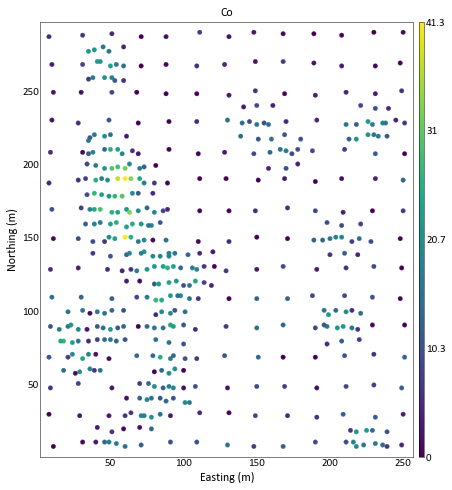

In [3]:
_ = gs.location_plot(walker_lake, var='Co')

# Sampling walker lake and getting the complement

In [4]:
import random
idxs = random.sample([x for x in range(walker_lake.shape[0])], 100)
comp_idx = []
for i in range(walker_lake.shape[0]):
    if i not in idxs:
        comp_idx.append(i)
comp_idx = np.array(comp_idx)

In [5]:
sampled = walker_lake.data.loc[idxs]
sampled = gs.DataFile(data=sampled, x='X', y='Y')
gs.write_gslib(sampled, 'upgradable_data/sampled_walker.dat')
sampled = gs.DataFile('upgradable_data/sampled_walker.dat')

In [6]:
complement = walker_lake.data.loc[comp_idx]
complement = gs.DataFile(data=complement, x='X', y='Y')
gs.write_gslib(complement, 'data/complement.dat')

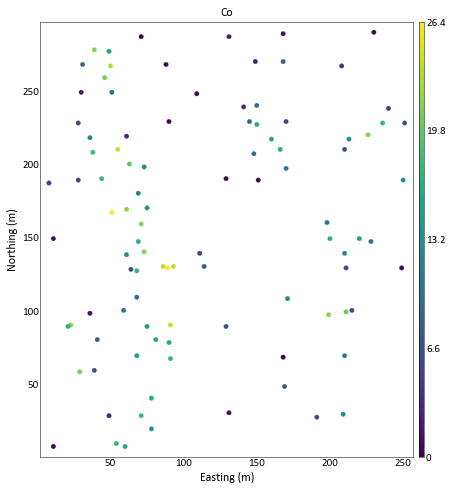

In [7]:
_ = gs.location_plot(sampled, var='Co')

# Kriging initial model

In [8]:
grid = walker_lake.infergriddef(blksize=(5, 5, 1))

In [9]:
kt3d = gs.Program('kt3d', getpar=True)

Unable to find the provided program! Trying to use the executable pool shipped with pygeostat!
C:\Users\Roberto Rolo\Documents\GitHub\model_updater\tmpurw9h4zq\kt3d.par has been copied to the clipboard


In [10]:
parstr = """                  Parameters for KT3D
                  *******************

START OF PARAMETERS:
{input_data}              -file with data
0  1  2  0  3  0                 -   columns for DH,X,Y,Z,var,sec var
-1.0e21   1.0e21                 -   trimming limits
0                                -option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          -file with jackknife data
1   2   0    3    0              -   columns for X,Y,Z,vr and sec var
3                                -debugging level: 0,1,2,3
outputs/kt3d.dbg                         -file for debugging output
{outfl}                         -file for kriged output
{griddef}
3    3      1                    -x,y and z block discretization
3    24                           -min, max data for kriging
0                                -max per octant (0-> not used)
200.0  200.0  1.0                 -maximum search radii
 0.0   0.0   0.0                 -angles for search ellipsoid
1     2.302                      -0=SK,1=OK,2=non-st SK,3=exdrift
0 0 0 0 0 0 0 0 0                -drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                -0, variable; 1, estimate trend
extdrift.dat                     -gridded file with drift/mean
4                                -  column number in gridded file
1    0                         -nst, nugget effect
1    1 160 0.0   0.0        -it,cc,ang1,ang2,ang3
         100  50  0.0        -a_hmax, a_hmin, a_vert
"""

pars = dict(input_data=sampled.flname,
            outfl = 'outputs/initial_model.out',
            griddef = grid)
kt3d.run(parstr=parstr.format(**pars),quiet=False, liveoutput=True, parfile='outputs/kt3dpar.par')

Calling:  ['C:\\Users\\Roberto Rolo\\anaconda3\\envs\\geostat\\lib\\site-packages\\pygeostat\\executable\\kt3d', 'outputs/kt3dpar.par']

KT3D Version: 2.907

 data file = upgradable_data/sampled_walker.dat      
 columns =           0           1           2           0           3
          0
 trimming limits =   -1.000000E+21    1.000000E+21
 kriging option =           0
 jackknife data file = xvk.dat                                 
 columns =           1           2           0           3           0
 debugging level =           3
 debugging file = outputs/kt3d.dbg                        
 output file = outputs/initial_model.out               
 nx, xmn, xsiz =          51        5.500000        5.000000
 ny, ymn, ysiz =          59        5.500000        5.000000
 nz, zmn, zsiz =           1    5.000000E-01        1.000000
 block discretization:          3           3           1
 ndmin,ndmax =           3          24
 max per octant =           0
 search radii =      200.000000  

In [11]:
model = gs.DataFile('outputs/initial_model.out', griddef=grid)

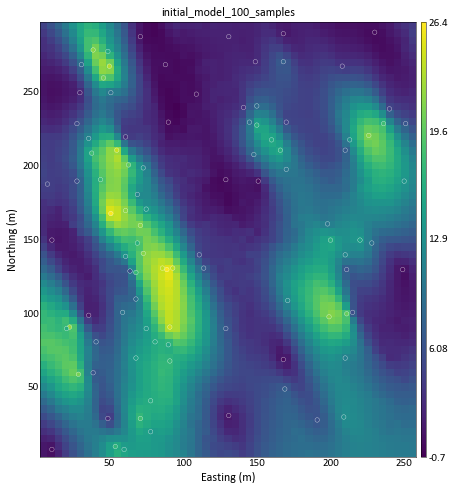

In [12]:
s = sampled.shape[0]
_ = gs.slice_plot(model, griddef=grid, output_file='images/initial_model_{}_samples.png'.format(s), title='initial_model_{}_samples'.format(s), pointdata=sampled, pointvar='Co', pointkws={'edgecolors':'white'})

# Starting to upgrade the model live

In [ ]:
import time
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler
from datetime import datetime, timedelta

class MyHandler(FileSystemEventHandler):
    def __init__(self):
        self.c = 0
        self.last_modified = datetime.now()
    
    def on_modified(self, event):
        #print(f'Event type: {event.event_type}  path : {event.src_path}')
        
        if event.src_path == 'upgradable_data/sampled_walker.dat'.replace('/', "\\"): #if you are on windows
            print('Diferença', datetime.now() - self.last_modified)
            if (datetime.now() - self.last_modified) < timedelta(seconds=6):
                return
            else:
                self.last_modified = datetime.now()
            
            print('Upgrading the model...')

            upgradaded_sampled_walker = gs.DataFile('upgradable_data/sampled_walker.dat')
            s = upgradaded_sampled_walker.shape[0]
            pars_n = dict(input_data=upgradaded_sampled_walker.flname,
                        outfl = 'outputs/model_{}.out'.format(self.c),
                        griddef = grid)
            kt3d.run(parstr=parstr.format(**pars_n),quiet=False, liveoutput=False)
            model = gs.DataFile('outputs/model_{}.out'.format(self.c), griddef=grid)
            _ = gs.slice_plot(model, griddef=grid, output_file='images/model_{}_{}_samples.png'.format(self.c, s), title='model_{}_{}_samples'.format(self.c, s), pointdata=upgradaded_sampled_walker, pointvar='Co', pointkws={'edgecolors':'white'})

            self.c = self.c + 1

event_handler = MyHandler()
observer = Observer()
observer.schedule(event_handler, path='upgradable_data', recursive=False)
observer.start()
print('I am Listening...')

try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    observer.stop()
observer.join()

# Enhancements

* Live model calibration
* Update only blocks inside the range of influence of the new samples